In [1]:
# import os
# import cv2
# import pytesseract
# from pytesseract import Output
# import shutil
# import re
# import numpy as np
# from ultralytics import YOLO


# def preprocess_for_ocr(image_bgr):
#     gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
#     # Contrast Limited Adaptive Histogram Equalization
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     eq = clahe.apply(gray)
#     # Mild denoise without killing edges
#     den = cv2.bilateralFilter(eq, d=7, sigmaColor=50, sigmaSpace=50)
#     # Adaptive threshold to get crisp digits
#     thr = cv2.adaptiveThreshold(den, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
#     # Ensure Tesseract sees dark text on light background; invert if mostly dark
#     if float(np.mean(thr)) < 127.0:
#         thr = cv2.bitwise_not(thr)
#     return thr


# def detect_and_segregate_bibs(image_dir, output_dir, conf_threshold=0.5, ocr_conf_threshold=60, min_len=2, max_len=5):
#     """
#     Detect bib numbers only inside detected person regions and segregate images
#     into folders named after bib numbers. Falls back to "unknown" if none found.
#     """
#     # Prepare
#     os.makedirs(output_dir, exist_ok=True)
#     model = YOLO("/Users/phoenixa/Documents/projects/marathon/yolov8n.pt" if os.path.exists("/Users/phoenixa/Documents/projects/marathon/yolov8n.pt") else "yolov8n.pt")
#     person_class_id = 0  # COCO 'person'

#     count = 0
#     for filename in os.listdir(image_dir):
#         if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
#             continue
#         print(f"[IMG] {count}: {filename}")
#         count += 1
#         path = os.path.join(image_dir, filename)
#         img = cv2.imread(path)
#         if img is None:
#             print("[WARN] Failed to read image, skipping")
#             continue

#         # Detect only persons
#         results = model.predict(source=img, classes=[person_class_id], conf=conf_threshold, iou=0.5, verbose=False)
#         bibs = set()

#         if len(results) > 0 and results[0].boxes is not None:
#             boxes = results[0].boxes
#             xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes.xyxy, "cpu") else boxes.xyxy
#             confs = boxes.conf.cpu().numpy() if hasattr(boxes.conf, "cpu") else boxes.conf
#             print(f"[DETECT] persons={len(xyxy)} (conf>={conf_threshold})")

#             for (x1, y1, x2, y2), det_conf in zip(xyxy, confs):
#                 x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
#                 x1 = max(0, x1); y1 = max(0, y1); x2 = min(img.shape[1], x2); y2 = min(img.shape[0], y2)
#                 if x2 <= x1 or y2 <= y1:
#                     continue

#                 crop = img[y1:y2, x1:x2]
#                 if crop.size == 0:
#                     continue
#                 print(f"  [BOX] ({x1},{y1},{x2},{y2}) conf={float(det_conf):.2f}")

#                 prep = preprocess_for_ocr(crop)

#                 # Tesseract config: digits only, assume a block of text
#                 # Enable auto-inversion so white-on-dark text is handled
#                 config = "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789 -c tessedit_do_invert=1"
#                 data = pytesseract.image_to_data(prep, output_type=Output.DICT, config=config)
#                 for i, text in enumerate(data.get("text", [])):
#                     text_clean = re.sub(r"[^0-9]", "", (text or "").strip())
#                     if not text_clean:
#                         continue
#                     if not (min_len <= len(text_clean) <= max_len):
#                         continue
#                     conf_str = data.get("conf", ["-1"])[i]
#                     try:
#                         conf_val = float(conf_str)
#                     except Exception:
#                         conf_val = -1.0
#                     if conf_val < ocr_conf_threshold:
#                         continue
#                     bibs.add(text_clean)
#                     print(f"    [BIB] {text_clean} (OCR conf={conf_val:.1f})")

#         if not bibs:
#             bibs = {"unknown"}
#         print(f"[SUMMARY] {filename}: {sorted(list(bibs))}")

#         for bib in bibs:
#             bib_folder = os.path.join(output_dir, str(bib))
#             os.makedirs(bib_folder, exist_ok=True)
#             target_path = os.path.join(bib_folder, filename)
#             if not os.path.exists(target_path):
#                 shutil.copy2(path, target_path)
#                 print(f"[SAVE] -> {bib_folder}/{filename}")


# # Example usage:
# image_dir = "/Users/phoenixa/Documents/projects/marathon/Edited"
# output_dir = "/Users/phoenixa/Documents/projects/marathon/output"
# detect_and_segregate_bibs(image_dir, output_dir)


In [ ]:
import os
import cv2
import re
import numpy as np
import easyocr
from ultralytics import YOLO


def preprocess_for_ocr(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    # Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq = clahe.apply(gray)
    # Mild denoise without killing edges
    den = cv2.bilateralFilter(eq, d=7, sigmaColor=50, sigmaSpace=50)
    # Adaptive threshold to get crisp digits
    thr = cv2.adaptiveThreshold(den, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    # Ensure Tesseract sees dark text on light background; invert if mostly dark
    if float(np.mean(thr)) < 127.0:
        thr = cv2.bitwise_not(thr)
    return thr

def detect_and_tabulate_bibs_easyocr(
    image_dir,
    conf_threshold=0.5,
    ocr_conf_threshold=0.6,
    min_len=2,
    max_len=5
):
    """
    Instead of separating and saving images, maintain a table with bib number and the photos in which they appear.
    Returns a sorted list of detected bib numbers at the end of processing.
    - conf_threshold: YOLO person detection confidence threshold
    - ocr_conf_threshold: EasyOCR confidence threshold in [0, 1]
    - min_len/max_len: min/max length of bib number string to keep
    """

    # Model load (same as original cell)
    model = YOLO(
        "/Users/phoenixa/Documents/projects/marathon/yolov8n.pt"
        if os.path.exists("/Users/phoenixa/Documents/projects/marathon/yolov8n.pt")
        else "yolov8n.pt"
    )
    person_class_id = 0

    # EasyOCR reader (English, CPU/GPU auto)
    reader = easyocr.Reader(["en"], gpu=True)

    # The bib mapping: bib_num -> set of image filenames
    bib_to_images = {}

    count = 0
    filenames = sorted(os.listdir(image_dir))
    for filename in filenames:
        if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            continue
        print(f"[IMG] {count}: {filename}")
        count += 1
        path = os.path.join(image_dir, filename)
        img = cv2.imread(path)
        if img is None:
            print("[WARN] Failed to read image, skipping")
            continue

        # Detect persons only
        results = model.predict(
            source=img, classes=[person_class_id], conf=conf_threshold, iou=0.5, verbose=False
        )
        bibs = set()

        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes.xyxy, "cpu") else boxes.xyxy
            confs = boxes.conf.cpu().numpy() if hasattr(boxes.conf, "cpu") else boxes.conf
            print(f"[DETECT] persons={len(xyxy)} (conf>={conf_threshold})")

            for (x1, y1, x2, y2), det_conf in zip(xyxy, confs):
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                x1 = max(0, x1); y1 = max(0, y1); x2 = min(img.shape[1], x2); y2 = min(img.shape[0], y2)
                if x2 <= x1 or y2 <= y1:
                    continue

                crop = img[y1:y2, x1:x2]
                if crop.size == 0:
                    continue
                print(f"  [BOX] ({x1},{y1},{x2},{y2}) conf={float(det_conf):.2f}")

                # Reuse same preprocessing from the original cell if available
                try:
                    prep = preprocess_for_ocr(crop)
                except NameError:
                    # Fallback simple grayscale if preprocess_for_ocr is not defined
                    prep = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

                # EasyOCR expects BGR/RGB or grayscale; detail=1 returns (bbox, text, conf)
                ocr_results = reader.readtext(
                    prep, detail=1, paragraph=False, slope_ths=0.1, height_ths=0.5
                )
                for bbox, text, conf in ocr_results:
                    text_clean = re.sub(r"[^0-9]", "", (text or "").strip())
                    if not text_clean:
                        continue
                    if not (min_len <= len(text_clean) <= max_len):
                        continue
                    if conf < ocr_conf_threshold:
                        continue
                    bibs.add(text_clean)
                    print(f"    [BIB] {text_clean} (OCR conf={conf:.2f})")

        if not bibs:
            bibs = {"unknown"}
        print(f"[SUMMARY] {filename}: {sorted(list(bibs))}")

        for bib in bibs:
            if bib not in bib_to_images:
                bib_to_images[bib] = set()
            bib_to_images[bib].add(filename)

    print(f"[COMPLETE] Processed {count} images.")
    return sorted(bib_to_images.keys())

# Example usage:
image_dir = "/Users/phoenixa/Documents/projects/marathon/Edited"
bib_numbers = detect_and_tabulate_bibs_easyocr(image_dir)
print(f"Detected bib numbers: {bib_numbers}")



[IMG] 0: Sarthi Studios-10.jpg
[DETECT] persons=2 (conf>=0.5)
  [BOX] (2244,2719,2417,3272) conf=0.67
  [BOX] (2043,2693,2251,3252) conf=0.52
[SUMMARY] Sarthi Studios-10.jpg: ['unknown']
[IMG] 1: Sarthi Studios-100.jpg
[DETECT] persons=5 (conf>=0.5)
  [BOX] (1270,2300,1963,4112) conf=0.85


/opt/anaconda3/envs/marathon/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


    [BIB] 5059 (OCR conf=1.00)
  [BOX] (3136,1788,3997,4193) conf=0.77
  [BOX] (2395,2043,2927,3748) conf=0.59
    [BIB] 5089 (OCR conf=0.99)
  [BOX] (3024,2153,3625,3998) conf=0.58
  [BOX] (1,2529,1127,5320) conf=0.58
[SUMMARY] Sarthi Studios-100.jpg: ['5059', '5089']
[IMG] 2: Sarthi Studios-1000.jpg
[DETECT] persons=9 (conf>=0.5)
  [BOX] (2213,2698,2918,4573) conf=0.86
    [BIB] 1075 (OCR conf=0.90)
  [BOX] (1712,2863,2128,4188) conf=0.75
    [BIB] 5040 (OCR conf=1.00)
  [BOX] (1128,2710,1576,4025) conf=0.73
  [BOX] (4,2624,683,5309) conf=0.69
  [BOX] (1428,2653,1764,3808) conf=0.65
  [BOX] (2823,2593,3462,3885) conf=0.65
  [BOX] (3317,2622,3739,3884) conf=0.63
  [BOX] (2736,2821,3064,3946) conf=0.53
  [BOX] (2048,2735,2354,4131) conf=0.51
    [BIB] 6010 (OCR conf=0.99)
[SUMMARY] Sarthi Studios-1000.jpg: ['1075', '5040', '6010']
[IMG] 3: Sarthi Studios-1001.jpg
[DETECT] persons=7 (conf>=0.5)
  [BOX] (4,2911,989,5941) conf=0.90
  [BOX] (2733,3065,3650,5486) conf=0.88
  [BOX] (1968,332

KeyboardInterrupt: 

[DETECT] persons=4 (conf>=0.5)
  [BOX] (1355,1513,2415,4908) conf=0.92
    [BIB] 5026 (OCR conf=1.00)
    [BIB] 271 (OCR conf=1.00)
  [BOX] (3012,2773,3592,4474) conf=0.88
  [BOX] (632,3003,1173,4394) conf=0.87
  [BOX] (3455,3660,3602,4094) conf=0.57
[SUMMARY] /Users/phoenixa/Documents/projects/marathon/Edited/Sarthi Studios-215.jpg: ['271', '5026']
Detected bib numbers: ['271', '5026']


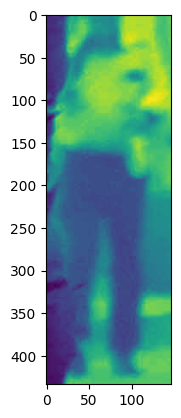

In [5]:
import cv2
import os
import re
import numpy as np
import easyocr
from ultralytics import YOLO
import matplotlib.pyplot as plt

def preprocess_for_ocr(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq = clahe.apply(gray)
    den = cv2.bilateralFilter(eq, d=7, sigmaColor=50, sigmaSpace=50)
    thr = cv2.adaptiveThreshold(den, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    if float(np.mean(thr)) < 127.0:
        thr = cv2.bitwise_not(thr)
    return thr

def detect_and_show_bibs_in_image(
    image_path,
    conf_threshold=0.5,
    ocr_conf_threshold=0.6,
    min_len=2,
    max_len=5
):
    """
    Detects persons in the given image using YOLO, applies OCR to each box, highlights boxes, and prints/display results.
    - image_path: path to the single image file
    Returns: detected bib numbers (list of str)
    """
    model = YOLO(
        "/Users/phoenixa/Documents/projects/marathon/yolov8n.pt"
        if os.path.exists("/Users/phoenixa/Documents/projects/marathon/yolov8n.pt")
        else "yolov8n.pt"
    )
    person_class_id = 0
    reader = easyocr.Reader(["en"], gpu=True)

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image: {image_path}")

    results = model.predict(
        source=img, classes=[person_class_id], conf=conf_threshold, iou=0.5, verbose=False
    )
    bibs = set()
    out_img = img.copy()
    box_colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)] # For easy viewing

    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes.xyxy, "cpu") else boxes.xyxy
        confs = boxes.conf.cpu().numpy() if hasattr(boxes.conf, "cpu") else boxes.conf
        print(f"[DETECT] persons={len(xyxy)} (conf>={conf_threshold})")

        for idx, ((x1, y1, x2, y2), det_conf) in enumerate(zip(xyxy, confs)):
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            x1 = max(0, x1); y1 = max(0, y1); x2 = min(img.shape[1], x2); y2 = min(img.shape[0], y2)
            if x2 <= x1 or y2 <= y1:
                continue
            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            print(f"  [BOX] ({x1},{y1},{x2},{y2}) conf={float(det_conf):.2f}")

            # Highlight the detected box
            color = box_colors[idx % len(box_colors)]
            cv2.rectangle(out_img, (x1, y1), (x2, y2), color, thickness=2)

            # try:
            #     prep = preprocess_for_ocr(crop)
            #     plt.imshow(prep)

            # except NameError:
            #     prep = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            prep = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            plt.imshow(prep)

            ocr_results = reader.readtext(
                prep, detail=1, paragraph=False, slope_ths=0.1, height_ths=0.5
            )
            for bbox, text, conf in ocr_results:
                text_clean = re.sub(r"[^0-9]", "", (text or "").strip())
                if not text_clean:
                    continue
                if not (min_len <= len(text_clean) <= max_len):
                    continue
                if conf < ocr_conf_threshold:
                    continue
                bibs.add(text_clean)
                print(f"    [BIB] {text_clean} (OCR conf={conf:.2f})")
                # Draw OCR'd bib on the image
                cv2.putText(out_img, f"{text_clean} ({conf:.2f})", (x1+5, y1+25+20*idx), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    if not bibs:
        bibs = {"unknown"}
    print(f"[SUMMARY] {image_path}: {sorted(list(bibs))}")

    # Show the image with highlighted boxes
    out_img_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    # plt.figure(figsize=(10,10))
    # plt.imshow(out_img_rgb)
    # plt.axis("off")
    # plt.title("YOLO Person Detections with Bibs (highlighted)")
    # plt.show()

    return sorted(bibs)

# Example usage:
image_path = "/Users/phoenixa/Documents/projects/marathon/Edited/Sarthi Studios-215.jpg"
bib_numbers = detect_and_show_bibs_in_image(image_path)
print(f"Detected bib numbers: {bib_numbers}")

